In [16]:
%%time
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from collections import OrderedDict

import time
import os, wget

import cudf
import cupy as cp

from cuml.decomposition import PCA

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

CPU times: user 86 µs, sys: 61 µs, total: 147 µs
Wall time: 151 µs


In [17]:
import rmm

rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Download

In [18]:
%%time
input_file = "../data/dsci_resting_nonzeropeaks.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/dsci_resting_nonzeropeaks.h5ad',
                  input_file)

adata = anndata.read_h5ad(input_file)
adata_raw = adata.copy()
print(adata.X.shape)

(60495, 143691)
CPU times: user 301 ms, sys: 348 ms, total: 649 ms
Wall time: 664 ms


## Process and cluster cells

In [19]:
%%time
lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

CPU times: user 2.24 s, sys: 1.07 s, total: 3.31 s
Wall time: 3.31 s


In [20]:
%%time
adata = utils.filter_peaks(adata, 20000)
print(adata.X.shape)

(60495, 20000)
CPU times: user 1.2 s, sys: 282 ms, total: 1.48 s
Wall time: 1.48 s


In [21]:
%%time
adata = anndata.AnnData(X=adata.X.todense(),
                        obs=adata.obs,
                        var=adata.var)
adata.obsm["X_pca"] = PCA(n_components=20).fit_transform(adata.X)
adata.obsm["X_pca"].shape

CPU times: user 28.6 s, sys: 31 s, total: 59.5 s
Wall time: 1min


(60495, 20)

In [22]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, method='rapids')

CPU times: user 5.97 s, sys: 7.26 s, total: 13.2 s
Wall time: 20.5 s


In [29]:
%%time
sc.tl.umap(adata, min_dist=0.5, method='rapids')

CPU times: user 659 ms, sys: 889 ms, total: 1.55 s
Wall time: 1.58 s


In [30]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

CPU times: user 94.3 ms, sys: 49.5 ms, total: 144 ms
Wall time: 142 ms


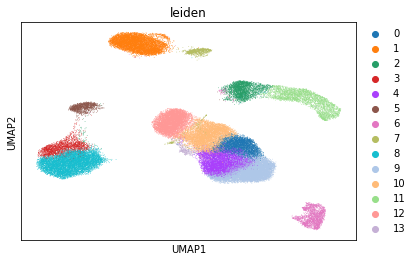

In [31]:
sc.pl.umap(adata, color=['leiden'])

## Create inputs for logistic regression

In [66]:
cluster_labels = np.array(adata.obs["leiden"], dtype='float32')
var_names = cudf.Series(adata.var_names)
reference_indices = cp.arange(len(var_names), dtype=int)

## Logistic regression using cuML and sklearn

In [67]:
from cuml.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', max_iter=100)
clf.fit(adata.X, cluster_labels)
scores_all = clf.coef_.T
scores_all[:5, :5]

array([[1.0233601 , 0.9664223 , 0.9979819 , 0.9886365 , 0.97280145],
       [0.98648125, 0.9773849 , 1.0081217 , 0.9956815 , 1.0050576 ],
       [0.9775847 , 1.0490167 , 1.0154297 , 1.0203238 , 1.0096698 ],
       [0.98582006, 1.0412701 , 0.9969158 , 0.9872022 , 0.9968276 ],
       [1.0131174 , 0.9735892 , 1.0038707 , 0.9671484 , 1.0523632 ]],
      dtype=float32)

In [68]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', max_iter=100, solver='lbfgs')
clf.fit(adata.X, cluster_labels)
scores_all_2 = clf.coef_
scores_all_2[:5, :5]

array([[-0.00738401, -0.03859438,  0.01247165, -0.01919843, -0.08909699],
       [ 0.00571146, -0.00765058,  0.02964478,  0.0048664 ,  0.0245076 ],
       [-0.01606481,  0.05579945,  0.01163   ,  0.04182953,  0.03162347],
       [-0.00608209,  0.00783478, -0.01886852,  0.00922388, -0.01311178],
       [-0.01210929, -0.11026211,  0.04439214, -0.13059344,  0.09837746]])

## Compare top 20 scoring regions identified in cluster 0 by sklearn and cuML

In [69]:
scores = scores_all[0]
partition = cp.argpartition(scores, -20)[-20:]
partial_indices = cp.argsort(scores[partition])[::-1]
global_indices = reference_indices[partition][partial_indices]
v1 = set(var_names[global_indices].to_pandas().index)

In [70]:
scores = scores_all_2[0]
partition = np.argpartition(scores, -20)[-20:]
partial_indices = np.argsort(scores[partition])[::-1]
global_indices = reference_indices.get()[partition][partial_indices]
v2 = set(var_names[global_indices].index.to_pandas())

In [71]:
print(v1.difference(v2))

{17664, 18756, 17004, 16511, 17038, 17326, 18799, 18577, 19345, 12819, 17428, 16567, 19098, 18239}
